 
# <span style="color:mediumblue">Concrete ML in action</span>


In the first demo, we showcase how to use build-in models, including: linear and tree-based models, using Concrete ML library.

For the second demo, we walk-though the process of converting custom Torch neural network to its FHE-equivalent.
(For NN, I'll walk you through the process in the second demo)

For each Concrete ML model, we will compare its execution time and performance to the standard scikit-learn counterpart.

calculele posterior du graphe tu fais la diff

##### <span style="color:skyblue">Import required libraries</span>

In [ ]:
import random
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from brevitas.nn import QuantLinear, QuantReLU
from brevitas.quant import Int8ActPerTensorFloat, Int8WeightPerTensorFloat
from sklearn.datasets import make_circles, make_classification, make_moons
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from utils_demo import (
    CustomDataset,
    CustomNeuralNet,
    plot_data,
    plot_datasets,
    plot_decision_boundary,
)

warnings.filterwarnings("ignore")

%matplotlib inline

### <span style="color:skyblue">Generate synthetic data-set</span>

We generate 3 synthetic data-sets for this demo. Where: 
- the first dataset is generated through make_classification, and it will be used for the linear model example
- the second a bit more complex is been generated through make_moons, which will be used for the tree-based model example.
- and finally the last dataset is generated using make circles that we will use for the neural network example.

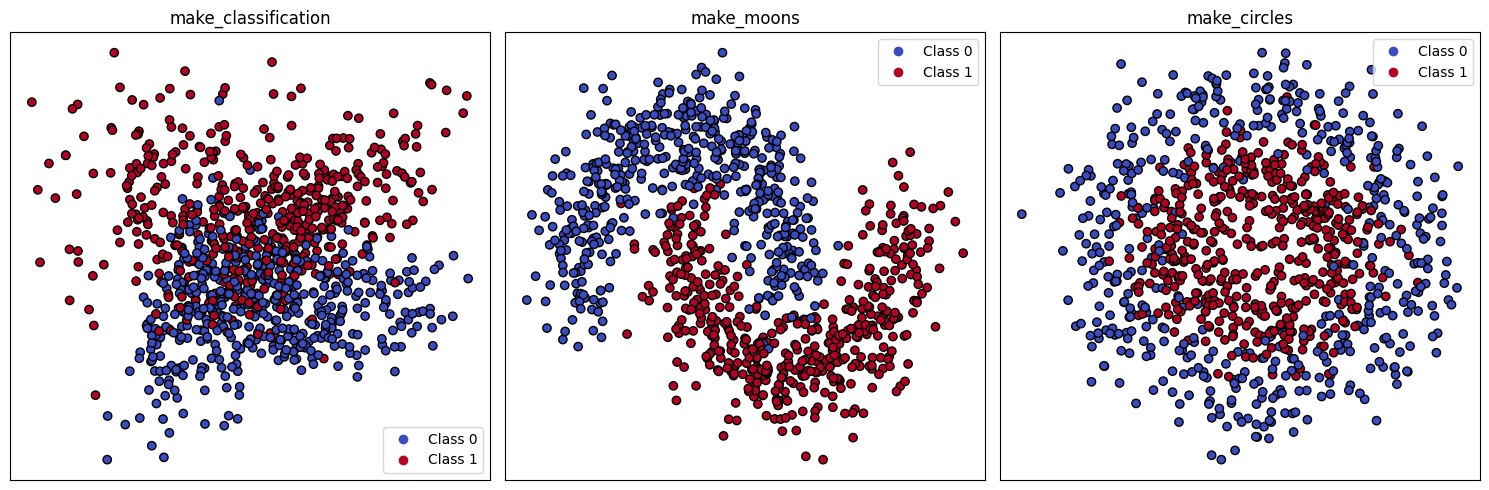

In [ ]:
linear_dataset, moon_dataset, circle_dataset = plot_datasets()

## <span style="color:royalblue">1. Linear models</span>

Gentle reminder:

Linear models are a family of algorithms in ML that aim to establish a linear relationship between input features and the target variable. So that the prediction is a weighted sum of the input features, to which a bias term can be added. 

The objective is to find the best weights and bias that minimize the difference between predicted and actual target values.
They are well-known for the simplicity and can be employed for regression and classification taskes. We can mention :
- Linear Regression
- Logistic Regression
- linear-kernel Support Vector Machines (SVM).

In this demo, I have selected logistic regression for a classification task.

In [ ]:
# Split the data-set into a train and testing sets
X_train, X_test, y_train, y_test = train_test_split(*linear_dataset, test_size=0.2, random_state=42)

# Shape
X_train.shape, X_test.shape

((800, 2), (200, 2))

### <span style="color:dodgerblue">1.1 Logistic Regression with scikit-learn</span>

Scikit-learn accuracy: 82.00%


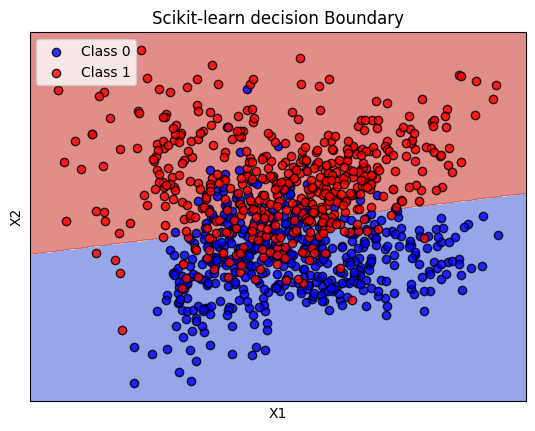

In [ ]:
from sklearn.linear_model import LogisticRegression as SklearnLogisticRegression

# Instanciate the model
sklearn_logit = SklearnLogisticRegression()

# Fit the model
sklearn_logit.fit(X_train, y_train)

# Predict
y_pred = sklearn_logit.predict(X_test)

# Evaluate the model
sklearn_accuracy = accuracy_score(y_test, y_pred)
print(f"Scikit-learn accuracy: {sklearn_accuracy:.2%}")

# Plot decision boundary
plot_decision_boundary(sklearn_logit, linear_dataset, "Scikit-learn")

### <span style="color:dodgerblue">1.2 Logistic Regression with Concrete ML</span>

Execution time in fhe: 0.0001 seconds per sample
Concrte ML accuracy with 3-bits: 80.00%


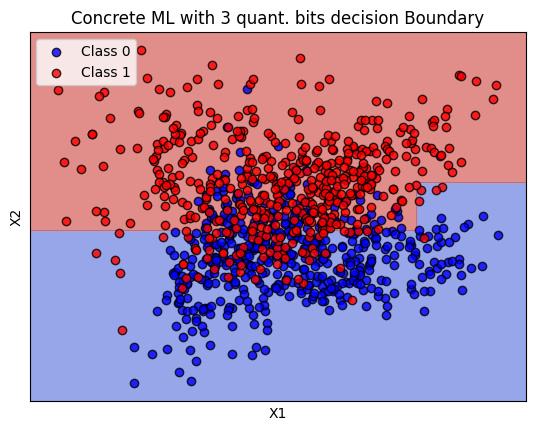

In [ ]:
from concrete.ml.sklearn import LogisticRegression as ConcreteLogisticRegression

# 1. Instanciate the model
# ConcreteLogisticRegression has the same attributes and methods as SklearnLogisticRegression
# The additional hyper-parameter is `n_bits` used for the quantization
concrete_logit = ConcreteLogisticRegression(n_bits=3)

# 2. The `fit` method is the same as the scikit-learn one
concrete_logit.fit(X_train, y_train)

# 3. compilation
# Like explained, you have to quantize the model, generate the FHE op. graph.
# With build-in models, everything is automated -> call the compile funtion and provide an exhaustive set of data
# For the quant. it will determine quant. params thanks to this X_train, PTQ
# From the crypto side:
# it creates the ops. grap (circuit), generates the crypto parameters and checks if the circuit is compliant with the FHE requirements: like
#  - bit-width inside the circuit must be less than 16-bits for custom models & decision trees, 25-bits for linear models -
#  - all intermediate values are properly quantized
fhe_circuit = concrete_logit.compile(X_train)

# Generate the keys
fhe_circuit.client.keygen(force=False)

# FHE inference
time_begin = time.time()
# fhe=disable, fhe=execute, fhe=simulate
y_pred_fhe = concrete_logit.predict(X_test, fhe="execute")
print(f"Execution time in fhe: {(time.time() - time_begin) / len(X_test):.4f} seconds per sample")

# Model evaluation
fhe_accuracy = accuracy_score(y_test, y_pred_fhe)
print(f"Concrte ML accuracy with {concrete_logit.n_bits}-bits: {fhe_accuracy:.2%}")

plot_decision_boundary(
    concrete_logit, linear_dataset, f"Concrete ML with {concrete_logit.n_bits} quant. bits"
)

In [ ]:
## Concrete ML vs scikit-learn:
print(f"Concrete ML accuracy: {fhe_accuracy:.2%} VS scikit-learn accuracy: {sklearn_accuracy:.2%}")

Concrete ML accuracy: 82.00% VS scikit-learn accuracy: 82.00%


Let's check the effect of the quantization on the decision boundary with `n_bits = 3`.

In [ ]:
## Concrete ML vs scikit-learn:
print(f"Concrete ML accuracy: {fhe_accuracy:.2%} VS scikit-learn accuracy: {sklearn_accuracy:.2%}")

Concrete ML accuracy: 80.00% VS scikit-learn accuracy: 50.00%


## <span style="color:royalblue">2. Tree-based models</span>

Gentle reminder:

Tree models are a class of machine learning algorithms that use a tree-like structure to make decisions based on input features. They recursively split the data into subsets, where each subset represents a branch or node in the tree. These models are commonly used for both regression and classification tasks. Tree models, such as Decision Trees and Random Forests, are interpretable and can capture non-linear relationships in the data. They partition the feature space into distinct regions, making them suitable for handling complex decision boundaries and handling missing values.


In [ ]:
# Split the data-set into a train and testing sets
X_train, X_test, y_train, y_test = train_test_split(*moon_dataset, test_size=0.3, random_state=42)

# Shape
X_train.shape, X_test.shape

((700, 2), (300, 2))

### <span style="color:dodgerblue">1.1 Tree-based models with scikit-learn</span>

Scikit-learn accuracy: 97.00%


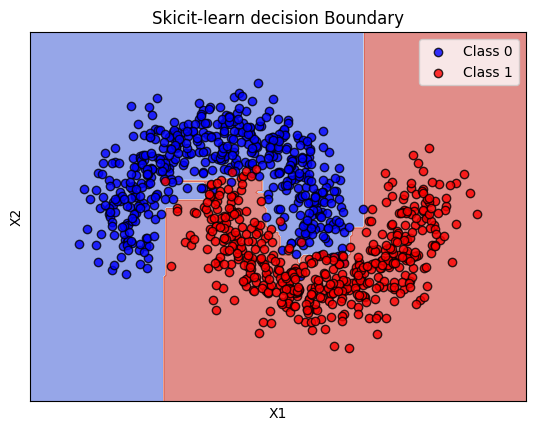

In [ ]:
from xgboost.sklearn import XGBClassifier as SklearnXGBClassifier

# Instanciate the model
sklearn_trees = SklearnXGBClassifier()

# Fit the model
sklearn_trees.fit(X_train, y_train)

# Predict
y_pred = sklearn_trees.predict(X_test)

# Evaluate the model
sklearn_accuracy = accuracy_score(y_test, y_pred)
print(f"Scikit-learn accuracy: {sklearn_accuracy:.2%}")

# Plot decision boundary
plot_decision_boundary(sklearn_trees, moon_dataset, "Skicit-learn")

### <span style="color:dodgerblue">1.2 Tree-based models with Concrete ML</span>

Compilation time: 0.37 s

Execution time in FHE: 61.3295 seconds per sample



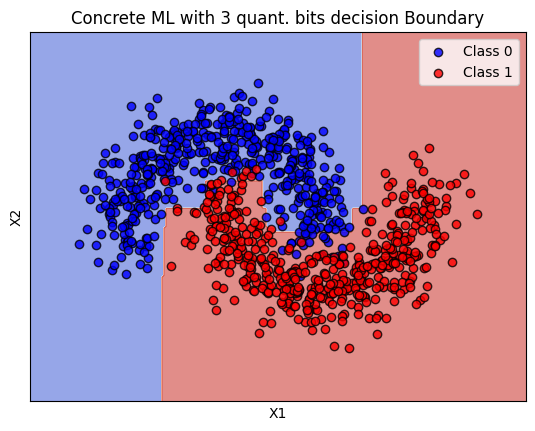

In [ ]:
from concrete.ml.sklearn import XGBClassifier as ConcreteXGBClassifier

# Quantization with Post Taining Quantization approach
concrete_trees = ConcreteXGBClassifier(n_bits=8)

# Fit the model using scikit-learn fit method
concrete_trees.fit(X_train, y_train)

# Compile the model
time_begin = time.time()
fhe_circuit = concrete_trees.compile(X_train)
print(f"Compilation time: {(time.time() - time_begin):.2f} s\n")

# generate the keys
fhe_circuit.client.keygen(force=False)

# Real FHE mode
time_begin = time.time()
y_pred_fhe = concrete_trees.predict(X_test[0, None], fhe="execute")
time_end = time.time()
print(f"Execution time in FHE: {(time_end- time_begin):.4f} seconds per sample\n")

# Predict
y_pred_fhe = concrete_trees.predict(X_test, fhe="simulate")
fhe_accuracy = accuracy_score(y_test, y_pred_fhe)

plot_decision_boundary(
    concrete_trees, moon_dataset, f"Concrete ML with {concrete_logit.n_bits} quant. bits"
)

In [ ]:
print(f"Execution time in FHE: {(time_end - time_begin):.4f} seconds per sample\n")

print(f"Concrete ML accuracy: {fhe_accuracy:.2%} VS Scikit-learn accuracy: {sklearn_accuracy:.2%}")

Execution time in FHE: 62.3382 seconds per sample

Concrete ML accuracy: 96.33% VS Scikit-learn accuracy: 97.00%


Plots
<!-- from concrete.ml.sklearn import XGBClassifier as ConcreteXGBClassifier

n_bits = [1, 2, 3, 4, 5, 6, 7, 8]

accuracy = []
accumulator_size = []
inference_time = []

X_train, X_test, y_train, y_test = train_test_split(*moon_dataset, test_size=0.2, random_state=42)

for bit in n_bits:
    concrete_trees = ConcreteXGBClassifier(n_bits=bit)
    concrete_trees.fit(X_train, y_train)
    fhe_circuit = concrete_trees.compile(X_train)
    accumulator_size.append(fhe_circuit.graph.maximum_integer_bit_width())
    fhe_circuit.client.keygen(force=False)
    time_start = time.time()
    y_pred_fhe = concrete_trees.predict(X_test[0], fhe="execute")
    inference_time.append(time.time() - time_start)
    y_pred = concrete_trees.predict(X_test, fhe="simulate")
    accuracy.append(accuracy_score(y_test, y_pred))

# Plot 1

# Set the background color to light yellow using Seaborn
sns.set_style("darkgrid")
# Create the scatter plot
plt.plot(n_bits, inference_time, marker="o", color='red', markersize=10, label="Inference time")

# Set the x and y-axis labels
plt.title("Inference time for different quantization bits for Concrete XGBoost Model", color='red')

plt.xlabel("Quantization bits")
plt.ylabel("Inference time in (seconds)")

# Show the plot
plt.legend(loc="best")

plt.show()


# Plot 2
plt.plot(n_bits, accuracy, marker="o", color='blue', markersize=10, label="Accuracy")

for x, y, acc in zip(n_bits, accuracy, accumulator_size):
    plt.annotate(str(acc), (x + .2, y), ha='center',
                 bbox=dict(boxstyle='square,pad=0.2', fc='white', ec='blue'))

plt.text(2.2, 0.34, "Accumulator Size", color='blue', ha='center', va='center', fontsize=12)

# Set the x and y-axis labels
plt.title("Accuracy for different quantization bits for Concrete XGBoost Model", color='blue')

plt.ylim(0, 1.1)
plt.xlabel("Quantization bits")
plt.ylabel("Top1 accuracy")

# Show the plot
plt.legend(loc="lower right")
plt.show()

# Plot 1

# Set the background color to light yellow using Seaborn
sns.set_style("darkgrid")
# Create the scatter plot
plt.plot(n_bits, inference_time, marker="o", color='red', markersize=10, label="Inference time")

# Set the x and y-axis labels
plt.title("Inference time for different quantization bits for Concrete XGBoost Model", color='red')

plt.xlabel("Quantization bits")
plt.ylabel("Inference time in (seconds)")

# Show the plot
plt.legend(loc="best")

plt.show()


# Plot 2
plt.plot(n_bits, accuracy, marker="o", color='blue', markersize=10, label="Accuracy")

for x, y, acc in zip(n_bits, accuracy, accumulator_size):
    plt.annotate(str(acc), (x + .2, y), ha='center',
                 bbox=dict(boxstyle='square,pad=0.2', fc='white', ec='blue'))

plt.text(2.2, 0.34, "Accumulator Size", color='blue', ha='center', va='center', fontsize=12)

# Set the x and y-axis labels
plt.title("Accuracy for different quantization bits for Concrete XGBoost Model", color='blue')

plt.ylim(0, 1.1)
plt.xlabel("Quantization bits")
plt.ylabel("Top1 accuracy")

# Show the plot
plt.legend(loc="lower right")
plt.show()

-->

Let's check the effect of the quantization on the decision boundary with `n_bits = 2`.

Concrete ML accuracy: 90.67% VS Scikit-learn accuracy: 97.00%


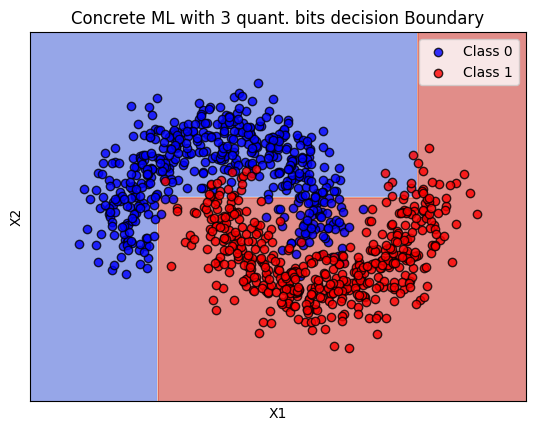

In [ ]:
concrete_trees = ConcreteXGBClassifier(n_bits=2)

concrete_trees.fit(X_train, y_train)

fhe_circuit = concrete_trees.compile(X_train)

fhe_circuit.client.keygen(force=False)

y_pred = concrete_trees.predict(X_test, fhe="simulate")

fhe_accuracy = accuracy_score(y_test, y_pred)

print(f"Concrete ML accuracy: {fhe_accuracy:.2%} VS Scikit-learn accuracy: {sklearn_accuracy:.2%}")

plot_decision_boundary(
    concrete_trees, moon_dataset, f"Concrete ML with {concrete_logit.n_bits} quant. bits"
)

## <span style="color:royalblue">3. Custom Neural Network </span>

I will show you how to convert any custom Torch neural network to its FHE-equivalent.

The development flow is as follows:

- You train your fp32 model, as you used to do 
- You quantize the model using the Brevitas library, in this demo, I've chosen the qat (quantization-aware training) approach.
- Then, you check if the quantized model complies with the FHE requirements before performing any computation to save time.
- I'll show 2 inference modes in practice: simulation mode and real FHE mode.

##### <span style="color:skyblue">Circle data-set</span>

In [ ]:
# Split the data-set into a train and testing sets
X_train, X_test, y_train, y_test = train_test_split(*circle_dataset, test_size=0.2, random_state=42)

# Convert the data to PyTorch tensors
X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train)
X_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test)

# Shape
X_train.shape, X_test.shape

(torch.Size([800, 2]), torch.Size([200, 2]))

##### <span style="color:skyblue">Import some helpers</span>

In [ ]:
from utils_demo import CustomNeuralNet, QuantCustomModel, mapping_keys, torch_evaluation, train

# For the compilation
from concrete.ml.torch.compile import compile_brevitas_qat_model

##### <span style="color:skyblue">Hyper-parameters</span>

In [ ]:
# Set the hyperparameters
neural_network_param = {"input_shape": 2, "output_shape": 2, "hidden_shape": 100}

device = "cpu"

##### <span style="color:skyblue">3.1 Train the FP32 model</span>

Let's take a live example.

Epoch [ 100 / 1000], Train Loss: 0.67, Test Loss: 0.68, Learning Rate: 0.0001
Epoch [ 200 / 1000], Train Loss: 0.64, Test Loss: 0.66, Learning Rate: 0.0001
Epoch [ 300 / 1000], Train Loss: 0.62, Test Loss: 0.64, Learning Rate: 0.0001
Epoch [ 400 / 1000], Train Loss: 0.59, Test Loss: 0.62, Learning Rate: 0.0001
Epoch [ 500 / 1000], Train Loss: 0.57, Test Loss: 0.60, Learning Rate: 0.0001
Epoch [ 600 / 1000], Train Loss: 0.54, Test Loss: 0.58, Learning Rate: 0.0001
Epoch [ 700 / 1000], Train Loss: 0.51, Test Loss: 0.56, Learning Rate: 0.0001
Epoch [ 800 / 1000], Train Loss: 0.48, Test Loss: 0.55, Learning Rate: 0.0001
Epoch [ 900 / 1000], Train Loss: 0.46, Test Loss: 0.53, Learning Rate: 0.0001
Epoch [1000 / 1000], Train Loss: 0.44, Test Loss: 0.51, Learning Rate: 0.0001

Train accuracy: 0.9075 vs Test accuracy: 0.815


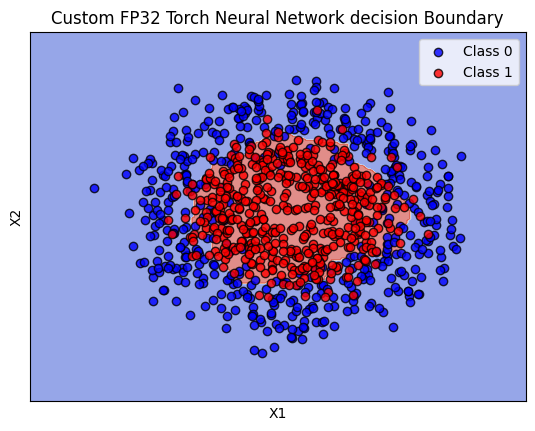

In [ ]:
# Initialize the FP32 neural network
fp32_nn = CustomNeuralNet(**neural_network_param)

do_training = True

if do_training:
    train(fp32_nn, X_train, X_test, y_train, y_test, seed=42, step=100, epochs=1000, verbose=True)

fp32_nn.load_state_dict(torch.load("custom_fp32_state_dict.pt"))

# Plot the decision boundary
plot_decision_boundary(fp32_nn, circle_dataset, "Custom FP32 Torch Neural Network")

##### <span style="color:skyblue">3.2 Quantize the FP32 model using Brevitas library</span>

In [ ]:
quantized_nn = QuantCustomModel(**neural_network_param, n_bits=3)

checkpoint = torch.load("custom_fp32_state_dict.pt")

quantized_nn = mapping_keys(checkpoint, quantized_nn, device)

# The accuracy drops
torch_evaluation(quantized_nn, X_test, y_test, device)

Accuracy: 0.535


##### <span style="color:skyblue">3.3 Fine-tune the quantized model</span>

In [ ]:
# Using the same the same function, with less epochs
train(
    quantized_nn,
    X_train,
    X_test,
    y_train,
    y_test,
    learning_rate=0.01,
    epochs=120,
    step=10,
    verbose=1,
    milestones=[16, 100],
)

Epoch [ 10 / 120], Train Loss: 1.43, Test Loss: 1.58, Learning Rate: 0.01
Epoch [ 20 / 120], Train Loss: 0.64, Test Loss: 0.78, Learning Rate: 0.001
Epoch [ 30 / 120], Train Loss: 0.64, Test Loss: 0.77, Learning Rate: 0.001
Epoch [ 40 / 120], Train Loss: 0.64, Test Loss: 0.77, Learning Rate: 0.001
Epoch [ 50 / 120], Train Loss: 0.55, Test Loss: 0.67, Learning Rate: 0.001
Epoch [ 60 / 120], Train Loss: 0.54, Test Loss: 0.68, Learning Rate: 0.001
Epoch [ 70 / 120], Train Loss: 0.48, Test Loss: 0.61, Learning Rate: 0.001
Epoch [ 80 / 120], Train Loss: 0.47, Test Loss: 0.59, Learning Rate: 0.001
Epoch [ 90 / 120], Train Loss: 0.43, Test Loss: 0.54, Learning Rate: 0.001
Epoch [100 / 120], Train Loss: 0.42, Test Loss: 0.53, Learning Rate: 0.0001
Epoch [110 / 120], Train Loss: 0.41, Test Loss: 0.52, Learning Rate: 0.0001
Epoch [120 / 120], Train Loss: 0.41, Test Loss: 0.52, Learning Rate: 0.0001

Train accuracy: 0.80375 vs Test accuracy: 0.75


##### <span style="color:skyblue">3.4 Check if the network is compliant</span>

In [ ]:
# If you reminder, for the build-in models, we used to compile the model
# We will do the same, for the NNs, thanks to this function

qmodel = compile_brevitas_qat_model(
    quantized_nn.to("cpu"),
    # Calibration data
    torch_inputset=X_train,
)

print(
    "The maximum bit-width in the circuit = "
    f"{qmodel.fhe_circuit.graph.maximum_integer_bit_width()} bits"
)

The maximum bit-width in the circuit = 6 bits


##### <span style="color:skyblue">3.5 Inference in FHE</span>

In [ ]:
# Let's measue the time inference for 1 example

time_start = time.time()
fhe_y_pred = qmodel.forward(X_test.numpy()[0][None], fhe="execute")
print(f"Execution time in FHE: {(time.time() - time_start):.4f} seconds per sample\n")

Execution time in FHE: 16.4552 seconds per sample



#### <span style="color:skyblue">Inference modes</span>

As you can see, the operations in Homomorphic Encryption can be quite costly. Actually it's proportional to the network size, input size, and precision bit-width in the circuit.

So, the Concrete ML library offers a cool feature, called **FHE simulation**. This simulation mimics the behavior of real Fully Homomorphic Encryption (FHE) computations, including the errors it could produce, while providing an oversight of the model's performance.

It's usefull for development phase, especially when several tests and iterations are required. 

##### <span style="color:skyblue">Inference in FHE simulation mode</span>

In [ ]:
fhe_y_pred = qmodel.forward(X_test.numpy(), fhe="simulate")

fhe_s_accuracy = (fhe_y_pred.argmax(1) == y_test.numpy()).mean()

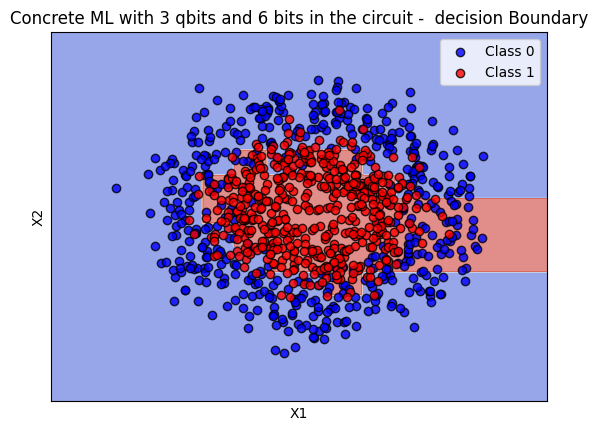

In [ ]:
title = (
    f"Concrete ML with {quantized_nn.n_bits} qbits and "
    f"{qmodel.fhe_circuit.graph.maximum_integer_bit_width()} bits in the circuit - "
)

plot_decision_boundary(quantized_nn, circle_dataset, title, qmodel)

With `n_bits=4`

Accuracy: 0.695
Epoch [ 10 / 120], Train Loss: 0.34, Test Loss: 0.59, Learning Rate: 0.01
Epoch [ 20 / 120], Train Loss: 0.29, Test Loss: 0.55, Learning Rate: 0.001
Epoch [ 30 / 120], Train Loss: 0.28, Test Loss: 0.53, Learning Rate: 0.001
Epoch [ 40 / 120], Train Loss: 0.28, Test Loss: 0.56, Learning Rate: 0.001
Epoch [ 50 / 120], Train Loss: 0.28, Test Loss: 0.57, Learning Rate: 0.001
Epoch [ 60 / 120], Train Loss: 0.27, Test Loss: 0.55, Learning Rate: 0.001
Epoch [ 70 / 120], Train Loss: 0.27, Test Loss: 0.55, Learning Rate: 0.001
Epoch [ 80 / 120], Train Loss: 0.27, Test Loss: 0.53, Learning Rate: 0.001
Epoch [ 90 / 120], Train Loss: 0.27, Test Loss: 0.53, Learning Rate: 0.001
Epoch [100 / 120], Train Loss: 0.27, Test Loss: 0.53, Learning Rate: 0.0001
Epoch [110 / 120], Train Loss: 0.27, Test Loss: 0.53, Learning Rate: 0.0001
Epoch [120 / 120], Train Loss: 0.27, Test Loss: 0.53, Learning Rate: 0.0001

Train accuracy: 0.9 vs Test accuracy: 0.795
The maximum bit-width in the circuit 

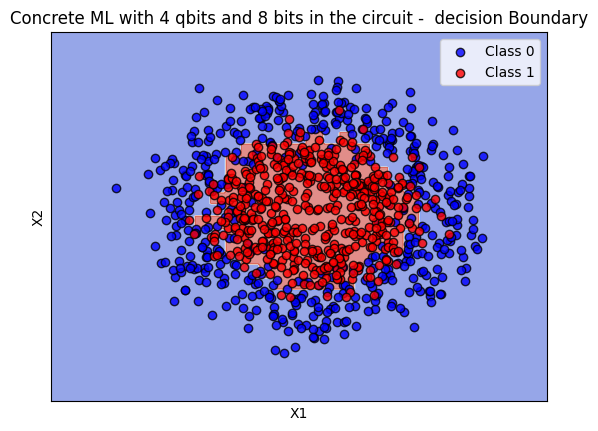

In [ ]:
quantized_nn = QuantCustomModel(**neural_network_param, n_bits=4)

checkpoint = torch.load("custom_fp32_state_dict.pt")

quantized_nn = mapping_keys(checkpoint, quantized_nn, device)

# The accuracy drops
torch_evaluation(quantized_nn, X_test, y_test, device)

# Using the same the same function, with less epochs
train(
    quantized_nn,
    X_train,
    X_test,
    y_train,
    y_test,
    learning_rate=0.01,
    epochs=120,
    step=10,
    verbose=1,
    milestones=[16, 100],
)

# If you reminder, for the build-in models, we used to compile the model
# We will do the same, for the NNs, thanks to this function

qmodel = compile_brevitas_qat_model(
    quantized_nn.to("cpu"),
    # Calibration data
    torch_inputset=X_train,
)

print(
    "The maximum bit-width in the circuit = "
    f"{qmodel.fhe_circuit.graph.maximum_integer_bit_width()} bits"
)

# Let's measue the time inference for 1 example

time_start = time.time()
fhe_y_pred = qmodel.forward(X_test.numpy()[0][None], fhe="execute")
print(f"Execution time in FHE: {(time.time() - time_start):.4f} seconds per sample\n")


fhe_y_pred = qmodel.forward(X_test.numpy(), fhe="simulate")

fhe_s_accuracy = (fhe_y_pred.argmax(1) == y_test.numpy()).mean()

title = (
    f"Concrete ML with {quantized_nn.n_bits} qbits and "
    f"{qmodel.fhe_circuit.graph.maximum_integer_bit_width()} bits in the circuit - "
)

plot_decision_boundary(quantized_nn, circle_dataset, title, qmodel)

In [ ]:
torch_evaluation(quantized_nn, X_test, y_test, device)

Accuracy: 0.795


## <span style="color:royalblue">3. Build-in Neural Network </span>

Gentle reminder: 

Neural networks are a class of machine learning models inspired by the structure and functioning of the human brain. They consist of interconnected nodes, called neurons, organized in layers. Each neuron takes inputs, applies weights and biases, and passes the result through an activation function. Neural networks are capable of learning complex patterns and relationships from data, making them powerful for various tasks, such as image recognition, natural language processing, and more.


### <span style="color:dodgerblue">1.1 Neural Network build-in model with scikit-learn</span>

In [ ]:
from sklearn.neural_network import MLPClassifier

neural_net_params = {
    "hidden_layer_sizes": (100, 2),
    "activation": "relu",
}

sklearn_nn = MLPClassifier(batch_size=32, **neural_net_params)

sklearn_nn.fit(X_train, y_train)

y_pred = sklearn_nn.predict(X_test)

sklearn_accuracy = accuracy_score(y_test, y_pred)

sklearn_accuracy

0.8

### <span style="color:dodgerblue">1.2 Neural Network build-in model with Concrete ML</span>

In [ ]:
from concrete.ml.sklearn import NeuralNetClassifier

neural_net_params = {
    "module__n_hidden_neurons_multiplier": 100,
    "module__n_layers": 2,  # 1 hidden layer
    "module__activation_function": torch.nn.ReLU,
    "module__n_w_bits": 7,
    "module__n_a_bits": 7,
    "module__n_accum_bits": 32,
    "verbose": 0,
}

concrete_nn = NeuralNetClassifier(batch_size=32, **neural_net_params)

concrete_nn.fit(X_train, y_train)

concrete_nn.compile(X_train)

y_pred_fhe = concrete_nn.predict(X_test, fhe="simulate")

fhe_accuracy = accuracy_score(y_test, y_pred_fhe)

fhe_accuracy

0.79

In [ ]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Charger un jeu de données (iris)
data = load_iris()
X = data.data
y = data.target

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Créer un pipeline avec une étape de mise à l'échelle et une étape de régression logistique
pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),  # Étape de mise à l'échelle
        ("classifier", LogisticRegression()),  # Étape de régression logistique
    ]
)

# Entraîner le modèle en utilisant le pipeline
pipeline.fit(X_train, y_train)

# Prédire les étiquettes sur l'ensemble de test
y_pred = pipeline.predict(X_test)

# Calculer la précision
accuracy = accuracy_score(y_test, y_pred)
print(f"Précision : {accuracy}")

Précision : 1.0


In [ ]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from concrete.ml.sklearn import LogisticRegression as ConcreteLogisticRegression

# Charger un jeu de données (iris)
data = load_iris()
X = data.data
y = data.target

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Créer un pipeline avec une étape de mise à l'échelle et une étape de régression logistique
pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),  # Étape de mise à l'échelle
        ("classifier", ConcreteLogisticRegression(n_bits=3)),  # Étape de régression logistique
    ]
)

# Entraîner le modèle en utilisant le pipeline
pipeline.fit(X_train, y_train)

# Prédire les étiquettes sur l'ensemble de test
y_pred = pipeline.predict(X_test)

# Calculer la précision
accuracy = accuracy_score(y_test, y_pred)
print(f"Précision : {accuracy}")

/home/celia/Desktop/Zama/concrete-ml-internal/.venv/lib/python3.10/site-packages/torch/cuda/__init__.py:88: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0
No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


Précision : 0.9


In [13]:
# Sigmoid in CML
# s(x) = 1/(1 + e−x)

import matplotlib.pyplot as plt
import numpy as np
import torch


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


x = np.array([0.2])
sigmoid(x), torch.nn.Sigmoid()(torch.tensor(x))

(array([0.549834]), tensor([0.5498], dtype=torch.float64))

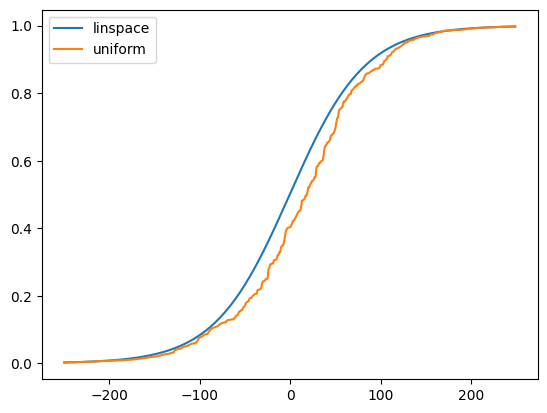

In [87]:
bit = 8

nb_points = 500
start, end = -6, 6
space1 = [sigmoid(x) for x in np.linspace(start, end, num=nb_points)]
space2 = sorted([sigmoid(x) for x in np.random.uniform(start, end, nb_points)])

plt.plot(range(-len(space1) // 2, len(space1) // 2), space1, label="linspace")
plt.plot(range(-len(space2) // 2, len(space2) // 2), space2, label="uniform")
plt.legend()

In [78]:
# from concrete.ml.quantization.quantizers import QuantizedArray

# quantizer_train = QuantizedArray(n_bits=8, values=space1)
# quantizer_train.quantizer.scale, quantizer_train.quantizer.zero_point, quantizer_train.quantizer.offset

offset = 0

scale = (np.max(space1) - np.min(space1)) / (2**bit - 1)

zp = np.round(
    (np.max(space1) * (-offset) - (np.min(space1) * (2**bit - 1 - offset)))
    / (np.max(space1) - np.min(space1))
).astype(np.int64)

scale, zp, offset

[0.5, 0.6607563687658172, 0.791391472673955, 0.8807970779778823, 0.935030830871336, 0.9655548043337887, 0.9820137900379085, 0.9906840406549333, 0.9951952471128405, 0.9975273768433653]


(0.001951087752326923, -256, 0)

In [80]:
import concrete.fhe as fhe
import matplotlib.pyplot as plt
import numpy as np
import torch


@fhe.compiler({"x": "encrypted"})
def fhe_sigmoid(x):
    return np.ceil(np.exp(-x))


b = 2
inputset = [(np.random.randint(1, 2**b, size=(1,))[0],) for _ in range(5)]
X_test = np.random.randint(1, 2**b, size=(1,))[0]
print(X_test)
fhe_sigmoid(X_test), X_test


# circuit = fhe_sigmoid.compile(inputset)
# circuit.encrypt_run_decrypt(X_test), fhe_sigmoid(X_test), X_test

2


(1.0, 2)